# Notebook for Optical Coherence Tomography (OCT) scan segmentation
##### This is the main notebook for the OCT scan segmentation. It contains the following sections:
- [necessary installs](#necessary-installs)
- [Library imports](#importing-the-libraries)
- [Data loading and preprocessing](#Data-loading-and-processing)
- [Model building](#Define-Model)
- [Model training](#training)
- [Results](#Results)
- [Plotting the results](#Plotting-the-predictions)

### necessary installs

In [2]:
! pip install patchify

^C


In [ ]:
! pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.9 MB/s 


### importing the libraries

In [ ]:
#from simple_multi_unet_model import multi_unet_model #Uses softmax 

import os
import glob
import cv2
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from keras.models import Model
from keras.metrics import MeanIoU
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from patchify import patchify, unpatchify
from tensorflow.keras.utils import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize, img_to_array, to_categorical
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


### Data loading and processing
- 1 Image imports
- 2 Image splitting
- 3 Image preprocessing

In [ ]:
# image and other parameters
SIZE_X = 512 # image hight
SIZE_Y = 1712 # image width

patch_size = (512, 512) # patchify patch size
window_step = 128 # patchify window step size
n_classes=4  # number of classes in the dataset (background, epidermis, dermis, subcutaneous)

batch_size = 16 # increase or decrease depending on your GPU

In [ ]:
# load the images and split them
train_images = [] # initialize empty list to store the images

# load, resize for consistency and split in to patches
for img_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/OCT_DATASET/Images", "*.BMP"))):
    img = cv2.imread(img_path, 0)
    p_imgs = patchify(img, patch_size, step=window_step).reshape(-1,*patch_size)
    # print(img.shape)      
    # img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(p_imgs)
    
train_images = np.concatenate(train_images)

In [ ]:
train_images.shape # check the shape of the train images array

(690, 512, 512, 3)

In [ ]:
# load the masks
train_masks = [] 
for mask_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/OCT_DATASET/Mask", "*.png"))):
    mask = cv2.imread(mask_path,cv2.IMREAD_UNCHANGED)
    p_imgs = patchify(mask, patch_size, step=window_step).reshape(-1,*patch_size)    
    #mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) 
    train_masks.append(p_imgs)
train_masks = np.concatenate(train_masks)

In [ ]:
train_masks.shape # check the shape of the train masks array

(690, 512, 512)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


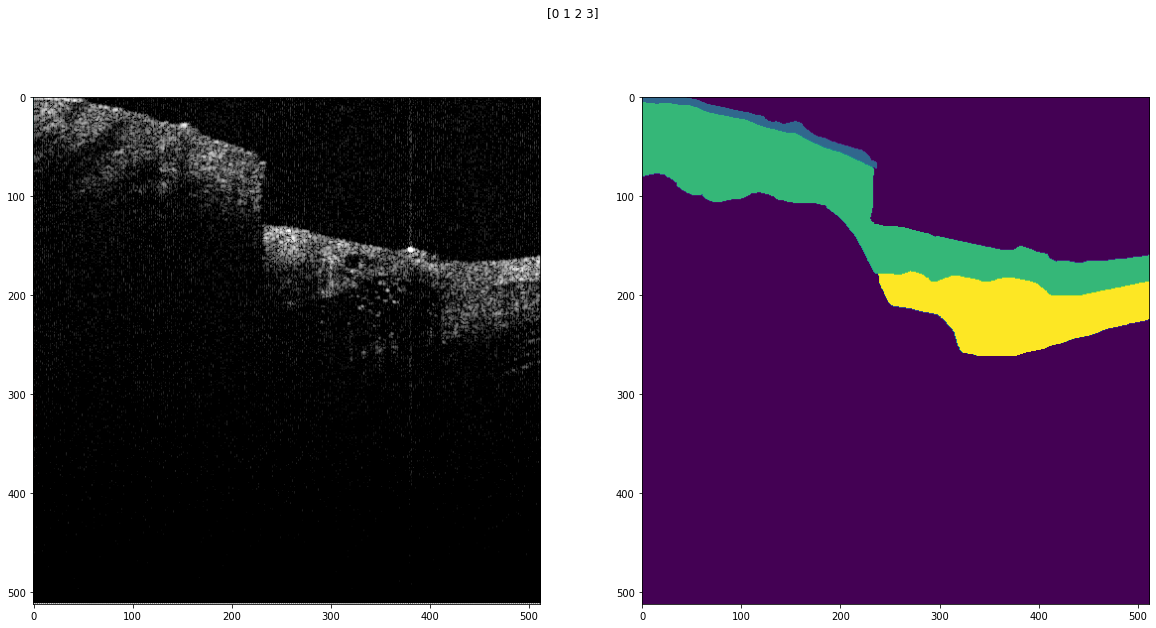

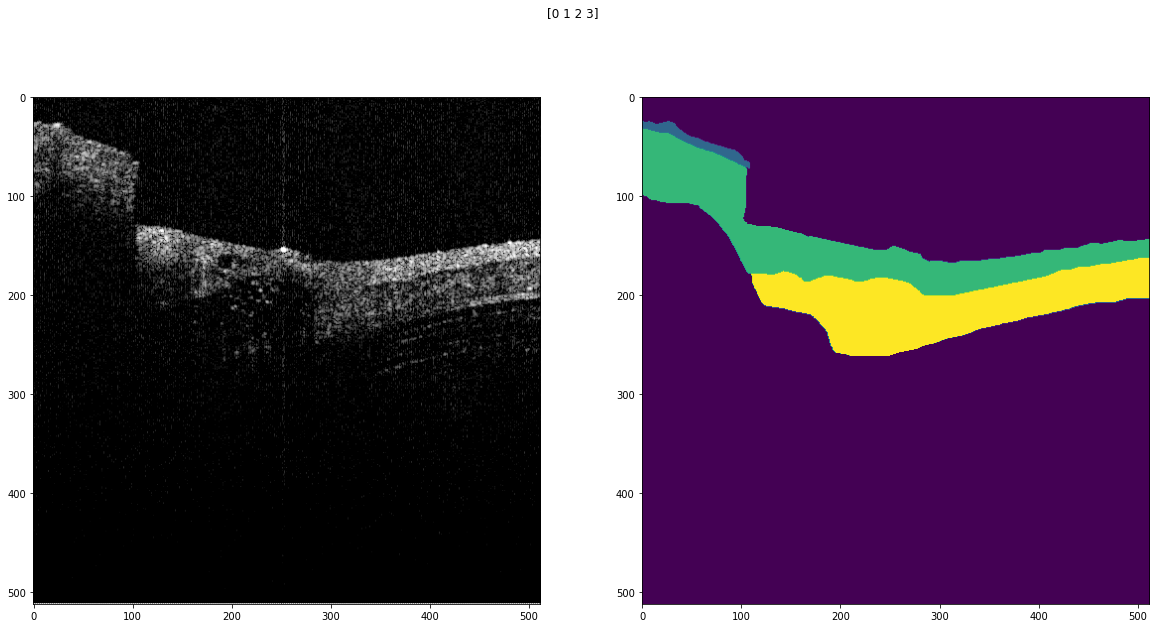

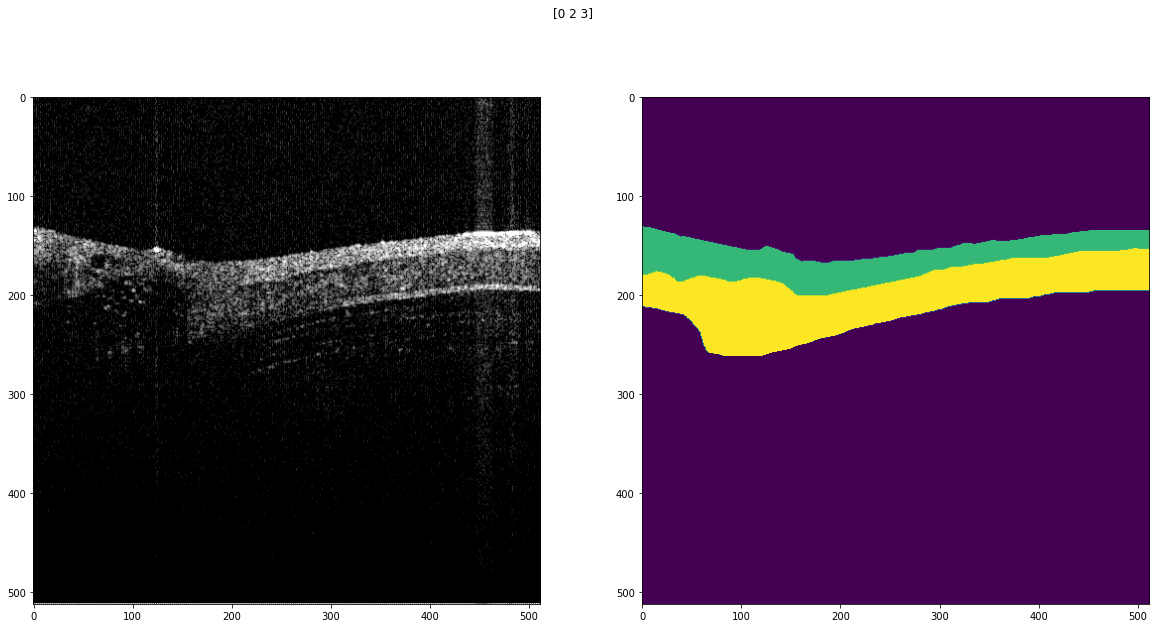

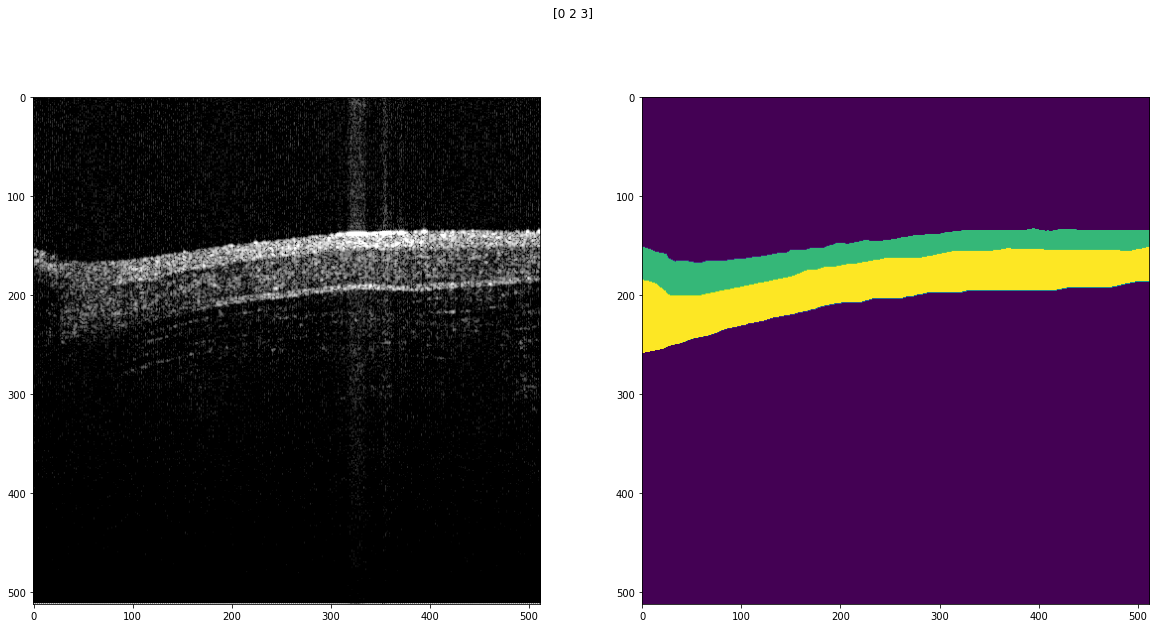

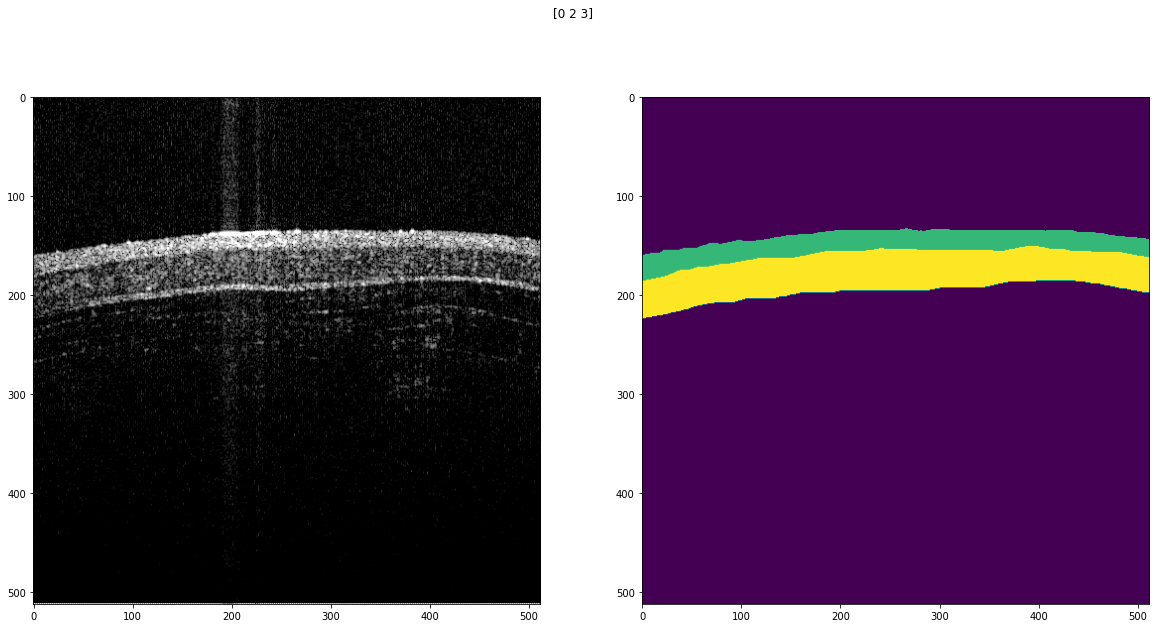

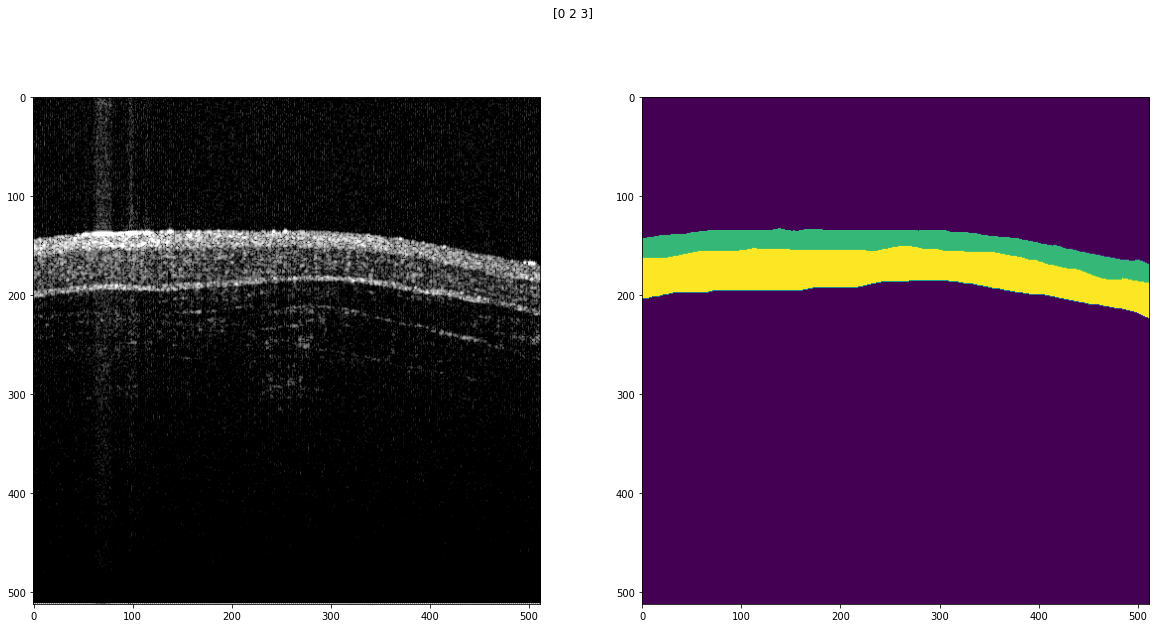

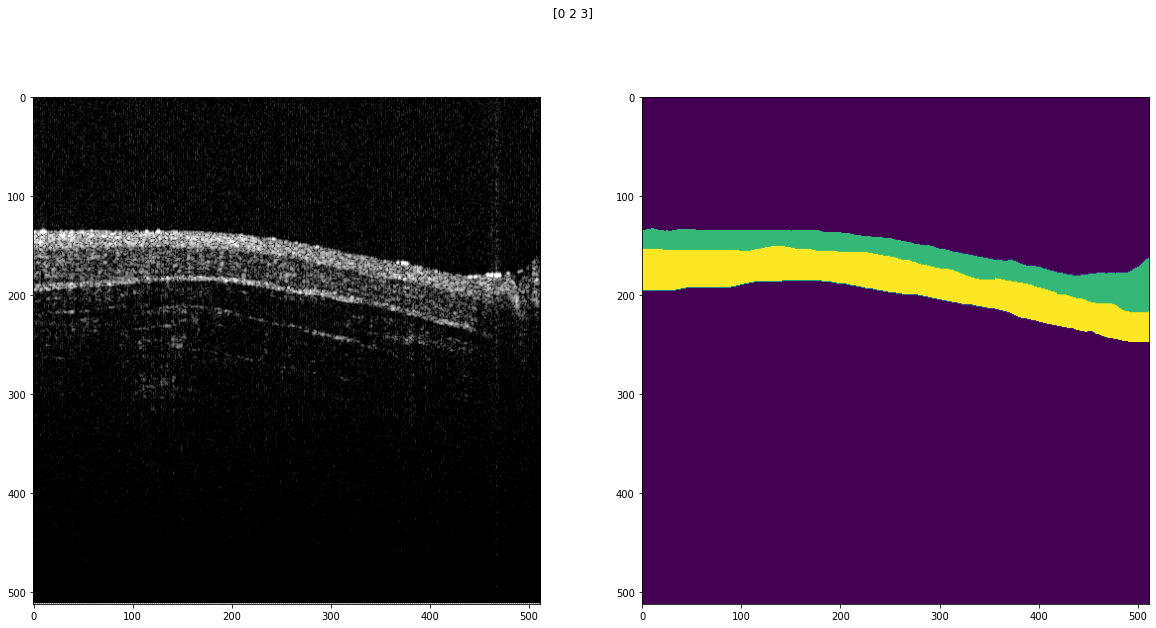

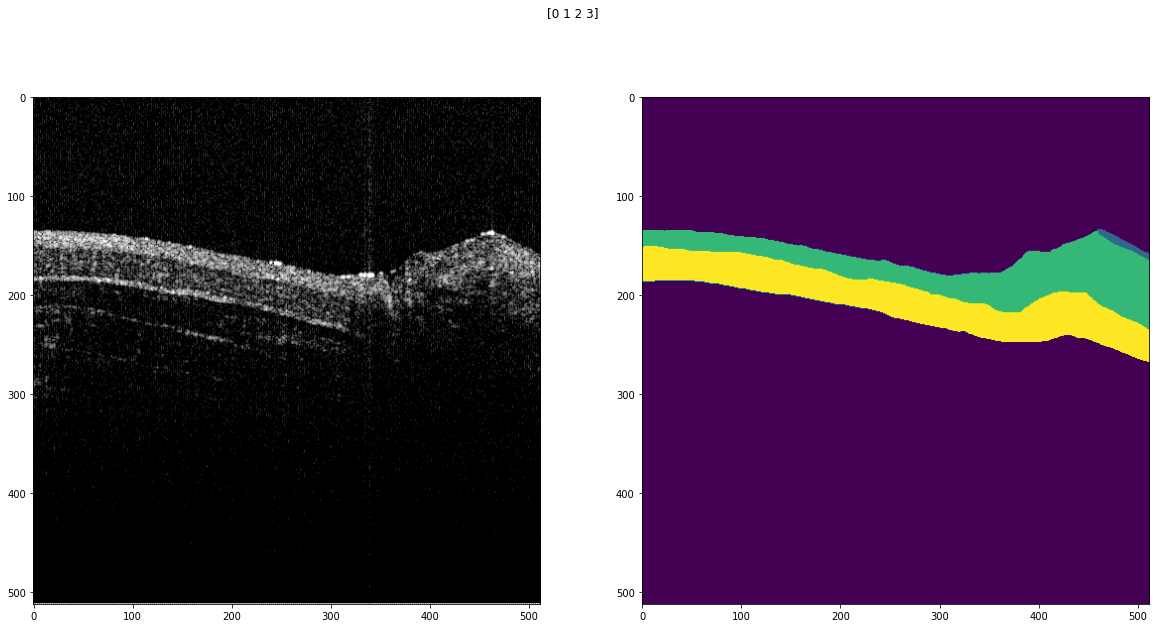

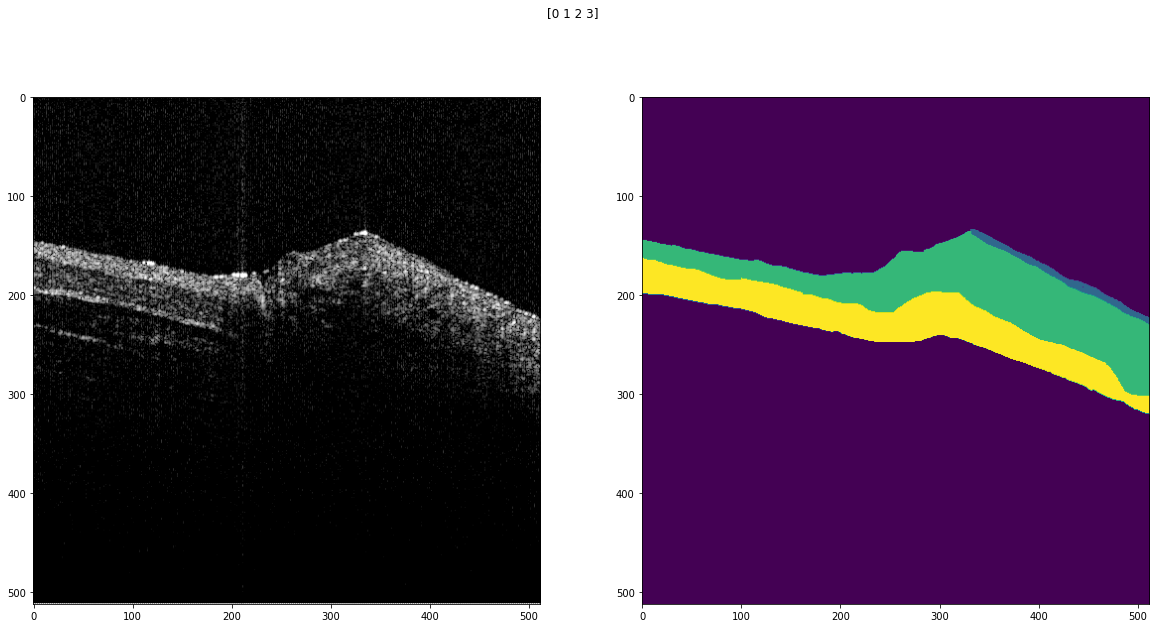

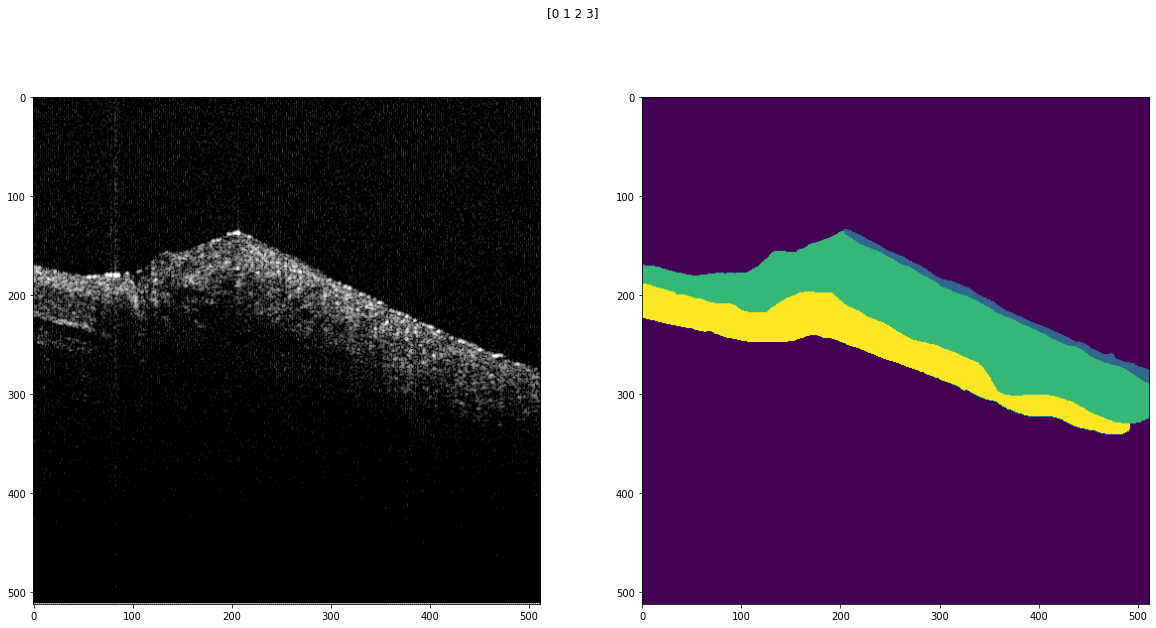

In [ ]:
# plot the patch images and masks
for i in range(10):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
  ax1.imshow(train_images[i], cmap="gray")
  ax2.imshow(train_masks[i])
  plt.suptitle(np.unique(train_masks[i]))
  plt.show()

#### Removing the patches with only backgrounds

In [ ]:
# remove the patches with only one class (this will remove the patches with only background, because the other patches will almost always have atleast 2 classes)
idx_lst = []
for i, single_mask in enumerate(train_masks):
  if len(np.unique(single_mask)) > 1:
    idx_lst.append(i)
len(idx_lst), train_images.shape, train_images[idx_lst].shape

(660, (690, 512, 512, 3), (660, 512, 512, 3))

In [ ]:
# take the patches with more than one class
train_images, train_masks = train_images[idx_lst], train_masks[idx_lst]

In [ ]:
# calculate the class weights
area = np.array([np.count_nonzero(train_masks==i) for i in [0,1,2,3]])
area/np.sum(area)

array([0.85472938, 0.01401643, 0.07984697, 0.05140721])

In [ ]:
# make the mask lebel values are 0,1,2,3
labelencoder = LabelEncoder() # define labelencoder
n, h, w = train_masks.shape # get the shape of masks array
train_masks_reshaped = train_masks.reshape(-1,1) # linearize the array
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped) # encode the labels
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w) # reshape again to the original shape

np.unique(train_masks_reshaped_encoded) # check the number of classes

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
# expand the dimensions to match the U-Net input
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
# split the dataset into train and test
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [ ]:
# keep 20% of train as validation
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [ ]:
# check the shape of the train and test split
X_train.shape, y_train.shape

((475, 512, 512, 1, 3), (475, 512, 512, 1))

In [ ]:
# transform the training masks to categorical format
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [ ]:
# transform the testing masks to categorical format
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
# adjust the class weights to counter the imbalance in the training data
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_masks_reshaped_encoded),y=train_masks_reshaped_encoded)

class_weights = {i:float(weight) for i, weight in enumerate(class_weights)}
#class_weights[0] = float(K.epsilon())
                                                
print("Class weights are...:", class_weights)

### Define Model

In [ ]:
# define the U-Net model
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

### Training

In [ ]:
# image parameters for the model
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
# get the model compile and summarize it
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# recheck the shape of the training and testing datasets
X_train.shape, y_train_cat.shape, X_test.shape, y_test_cat.shape

((475, 512, 512, 1, 3),
 (475, 512, 512, 4),
 (66, 512, 512, 1, 3),
 (66, 512, 512, 4))

In [1]:
# training and keeping the history of the model
history = model.fit(X_train, y_train_cat, 
                    batch_size = batch_size, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

### Results

#### Accuracy

In [ ]:
# check model accuracy
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 [==============================] - 2s 207ms/step - loss: 0.0417 - accuracy: 0.9861
Accuracy is =  98.60592484474182 %


#### train and validation loss

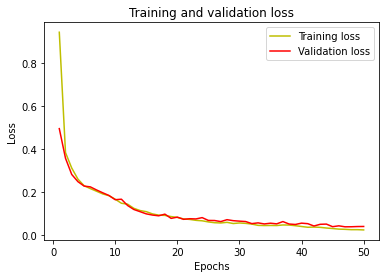

In [ ]:
# plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Mean IoU score

In [ ]:
# get the predictions for the test data
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
# check mean Intersection over Union score (IoU)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.90147394


#### IoU metric per class

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[1.4549244e+07 6.9680000e+03 7.9764000e+04 3.3612000e+04]
 [7.4300000e+03 2.1002400e+05 1.3297000e+04 8.5000000e+01]
 [1.5976000e+04 1.8759000e+04 1.3069830e+06 1.7545000e+04]
 [3.1133000e+04 0.0000000e+00 1.6626000e+04 9.9405800e+05]]
IoU for class1 is:  0.9881227
IoU for class2 is:  0.81860596
IoU for class3 is:  0.88973963
IoU for class4 is:  0.9094276


### Plotting the predictions

#### plotting predictions on patches

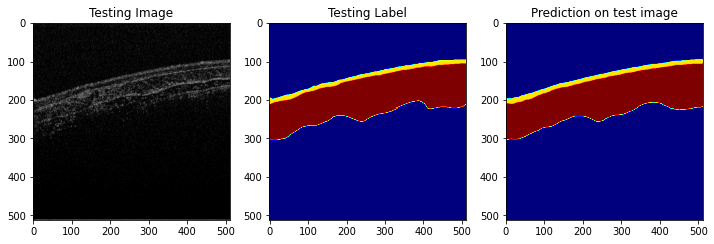

In [ ]:
## plotting patch segmentation results

#getting and preping prediction on test image
test_img_number = random.randint(0, len(X_test)) # take a random image patch
test_img = X_test[test_img_number] 
ground_truth=y_test[test_img_number] # mask for the test image patch
test_img_norm=test_img[:,:,0][:,:,None] # normalizing the test image patch
test_img_input=np.expand_dims(test_img_norm, 0) # expanding the dimensions for prediction
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

# plot the test image patch
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()